In [1]:
import imageio
import math

import numpy as np
import scipy as sp

from PIL import Image
from scipy import conj
from numpy.fft import fft2, ifft2

# Frequency Based Registration

Registration by sending the images into the Fourier domain and performing phase correlation on them. In the Inverse Fourier transform of this operation, the peak is where the images correlate the best. The point found represents the upper left corner of the moving image instead of the center as it does in the area based methods.

An interesting note on [`scipy.fftpack.fft`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html):  
    
> This function is most efficient when n is a power of two, and least efficient when n is prime.

In [13]:
def norm_cross_power_spectrum(i1, i2):
    assert i1.shape[0] == i2.shape[0] and i1.shape[1] == i2.shape[1], 'images are different sizes: %s v %s' % (i1.shape, i2.shape,)
    f1 = fft2(i1)
    f2 = fft2(i2)
    return (f1 * conj(f2)) / abs(f2 * conj(f2))

def cross_power_spetrum(i1, i2):
    assert i1.shape[0] == i2.shape[0] and i1.shape[1] == i2.shape[1], 'images are different sizes: %s v %s' % (i1.shape, i2.shape,)
    f1 = fft2(i1)
    f2 = fft2(i2)
    return (f1 * conj(f2)) / abs(f1 * conj(f2))

In [37]:
from operator import mul as mult

def NCC(i1, i2):
    '''
    Normalized cross correlation, maximize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes "%s" v "%s"' % (i1.shape, i2.shape,)
    f_err = i1 - i1.mean()
    t_err = i2 - i2.mean()
    nom = (f_err * t_err).sum()
    dnom = np.square(t_err).sum() * np.square(f_err).sum()
    if math.sqrt(dnom) == 0:
        return 0
    return nom / math.sqrt(dnom)

def test_corners(ref, mov, pt):
    '''
    Find the corner which matches to the found x,y point
    The corner to which this method matches can be ambiguous
    '''
    window = 33; # window size
    mw,mh = mov.shape
    rw,rh = ref.shape
    y,x = pt
    corrs = [] # tl, tr, br, bl

    # moving image corners
    tl = mov[0:window, 0:window]
    tr = mov[0:window, mw-window:mw]
    br = mov[mh-window:mh, mw-window:mw]
    bl = mov[mh-window:mh, 0:window]

    # reference corners around pt
    ref_tl = ref[y:min(y+window, rh), x:min(x+window, rw)]
    ref_tr = ref[y:min(y+window, rh), max(x-window,0):x]
    ref_br = ref[max(y-window,0):y,   max(x-window,0):x]
    ref_bl = ref[max(y-window,0):y,   x:min(x+window, rw)]

    # compare corners
    if mult(*ref_tl.shape) > 0:
       corrs.append(NCC(ref_tl, tl))
    else:
        corrs.append(-1)

    if mult(*ref_tr.shape) > 0:
        corrs.append(NCC(ref_tr, tr))
    else:
        corrs.append(-1)

    if mult(*ref_br.shape) > 0:
        corrs.append(NCC(ref_br, br))
    else:
        corrs.append(-1)

    if mult(*ref_bl.shape) > 0:
        corrs.append(NCC(ref_bl, bl))
    else:
        corrs.append(-1)

    print(corrs)
    # return the best one
    return np.argmax(corrs)

In [16]:
import matplotlib.pyplot as plt

def clamp(x, mn, mx):
    return max(mn, min(x, mx))

def show_registration(ref, mov, correlation, coord):
    fig, (a, b, corr) = plt.subplots(1, 3, figsize=(10, 18))
    
    a.imshow(ref, cmap='gray')
    a.set_title('Reference')
    a.plot(coord[0], coord[1], 'ro')
    
    b.imshow(mov, cmap='gray')
    b.set_title('Moving')
    
    # uncomment if you want to see the impulse peak.
#     w = 10
#     sy = clamp(y-w, 0, correlation.shape[1])
#     ey = clamp(y+w, 0, correlation.shape[1])
#     sx = clamp(x-w, 0, correlation.shape[0])
#     ex = clamp(x+w, 0, correlation.shape[0])
#     corr.imshow(np.real(correlation)[sy:ey,sx:ex])
    corr.imshow(np.real(correlation))  
    corr.set_title('phase-correlation')
    plt.show()

In [26]:
s = 1024
# s = 2048
newsize = (s,s)
temp1 = Image.open('../data/T1_segment_2.tif').resize(newsize)
temp2 = Image.open('../data/T1_segment_1.tif').resize(newsize)

In [27]:
dtype = 'float64'
im1 = np.array(temp1).astype(dtype)
im2 = np.array(temp2).astype(dtype)

# cps = convolve(im1, im2, cross_power)
impulse = ifft2(cross_power_spectrum(im1, im2))
y,x = np.unravel_index(np.argmax(impulse), impulse.shape)
x,y

(256, 0)

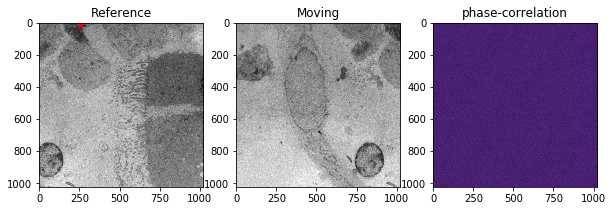

In [28]:
show_registration(im1, im2, impulse, (x,y))

To corner to which `x` and `y` references is ambiguous. Why and how to solve this? 
- ~~do both images need to be padded?~~ Still ambiguous
- Do more checks just need to be made about which corner `x,y` is refering too? → perform some cross-correlation on the corners?

In [38]:
test_corners(im1, im2, (y,x)) # tl, tr, bl, br

[-0.32605612672911827, 0.8871935914525386, -1, -1]


1

## With rotation

There is no iterative technique here, instead a log-polar transform is performed on the images and a phase correlation is run on the two images. The peaks detected correspond to the scale and rotation of the moving image.

- [OpenCV docs: warpPolar](https://docs.opencv.org/3.4.2/da/d54/group__imgproc__transform.html#ga49481ab24fdaa0ffa4d3e63d14c0d5e4)

In [14]:
import cv2

def polar_log(img, radius=2.0):
    '''
    Use this warp if there is some scale difference and rotation
    '''
    center = (img.shape[0] / 2, img.shape[1] / 2)
    radius = round(math.sqrt(center[0] ** radius + center[1] ** radius))
    return cv2.warpPolar(img, img.shape, center, radius, cv2.WARP_POLAR_LOG)

def tuple_sub(t1, t2):
    return (t1[0] - t2[0], t1[1] - t2[1])

def bounds_equalize(target, ref):
    yd,xd = tuple_sub(target.shape, ref.shape)
    if yd < 0:
        ref = ref[-yd//2:yd//2,:]
    else:
        ref = np.pad(ref, ((yd//2,yd//2), (0,0)), 'constant', constant_values=(0,0))
        
    if xd < 0:
        ref = ref[:,-xd//2:xd//2]
    else:
        ref = np.pad(ref, ((0,0), (xd//2,xd//2)), 'constant', constant_values=(0,0))
        
    return ref
    

(3516, 3516) (3516, 3516)


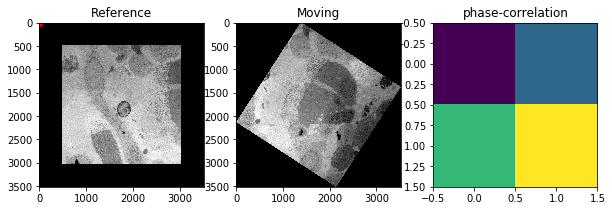

In [23]:
flags = cv2.IMREAD_UNCHANGED
temp1 = cv2.imread('../data/T1_segment_rot_1.tif', flags=flags).astype('float64')
temp2 = cv2.imread('../data/T1_segment_rot_2.tif', flags=flags).astype('float64')

temp1 = bounds_equalize(temp2, temp1)
print(temp1.shape, temp2.shape)

# these are resized inline
r = 1.0
new_size = (int(r * temp2.shape[0]), int(r * temp2.shape[1]))
temp1 = cv2.resize(temp1, new_size)
temp2 = cv2.resize(temp2, new_size)

show_registration(temp1, temp2, np.array([[1,2],[3,4]]), (0,0))

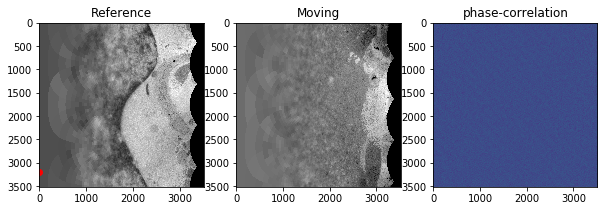

In [24]:
warp_fn = polar_log
im1_p = warp_fn(temp1)
im2_p = warp_fn(temp2)

impulse = ifft2(cross_power_spectrum(im1_p, im2_p))
theta, rho = np.unravel_index(np.argmax(impulse), impulse.shape)
show_registration(im1_p, im2_p, impulse, (rho, theta))

In [25]:
angle = theta * (360 / impulse.shape[0]) % 180
if angle < -90:
    angle += 180
elif angle > 90:
    angle -= 180
print(theta, rho, angle) # scale would be 1/(10 ** rho)

3194 0 -32.96928327645054
